In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.image import imread

from scipy.optimize import linprog
from scipy.fftpack import dct, idct

# Exercise 3-1
Load the image dog.jpg and convert to grayscale. We will repeat Exercise 2-1, using the FFT to compress the image at different compression ratios. However, now, we will compare the error versus compression ratio for the image downsampled at different resolutions. Compare the original image (2000×1500) and downsampled copies of the following resolutions: 1000×750, 500 × 375, 200 × 150, and 100 × 75. Plot the error versus compression ratio for each image resolution on the same plot. Explain the observed trends.

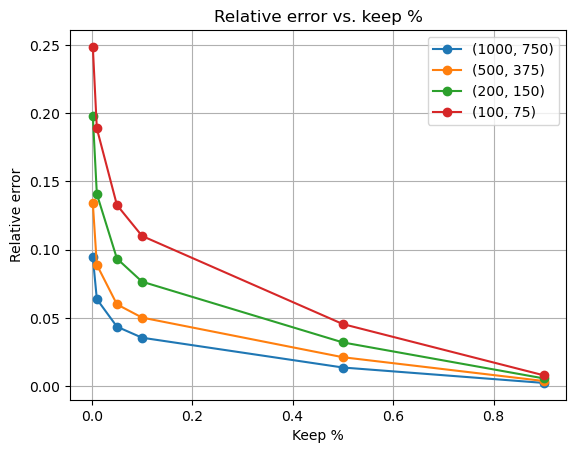

In [2]:
A = imread(os.path.join('..','DATA','dog.jpg'))
B = np.mean(A, -1); # Convert RGB to grayscale

resolutions = [(1000, 750), (500, 375), (200, 150), (100, 75)]
errors = []

keep = [0.9, 0.5, 0.1, 0.05, 0.01, 0.002]

for j in resolutions:

    downscaled_image = B[::A.shape[0]//j[0], ::A.shape[1]//j[1]]

    Bt = np.fft.fft2(downscaled_image)
    Btsort = np.sort(np.abs(Bt.reshape(-1))) # sort by magnitude

    temp = []

    for i in keep:
        thresh = Btsort[int(np.floor((1-i)*len(Btsort)))]
        ind = np.abs(Bt)>thresh          # Find small indices
        Atlow = Bt * ind                 # Threshold small indices
        Alow = np.fft.ifft2(Atlow).real  # Compressed image
        temp.append(np.linalg.norm(downscaled_image-Alow)/np.linalg.norm(downscaled_image))
    
    else:
        errors.append(temp)


for i, val in enumerate(errors):
    plt.plot(keep, val, 'o-', label = str(resolutions[i]))

plt.xlabel('Keep %')
plt.ylabel('Relative error')
plt.title('Relative error vs. keep %')
plt.legend()
plt.grid()
plt.show()

# Exercise 3-2

This example will explore geometry and sampling probabilities in high-dimensional spaces. Consider a two-dimensional square dart board with length $L = 2$ on both sides and a circle of radius $R = 1$ in the middle. Write a program to throw 10 000 darts by generating a uniform random $x$ and $y$ position on the square. Compute the radius for each point and compute what fraction
land inside the circle (i.e., how many have radius $\geq 1$). Is this consistent with your expectation based on the area of the circle and the square? Repeat this experiment, throwing 10 000 darts randomly (sampled from a uniform distribution) on an N-dimensional cube (length $L = 2$) with an N-dimensional sphere inside (radius $R = 1$), for $N = 2$ through $N = 10$. For a given N, what fraction of the points land inside the sphere. Plot this fraction versus N. Also compute the histogram of the radii of the randomly sampled points for each N and plot these. What trends do you notice in the data?

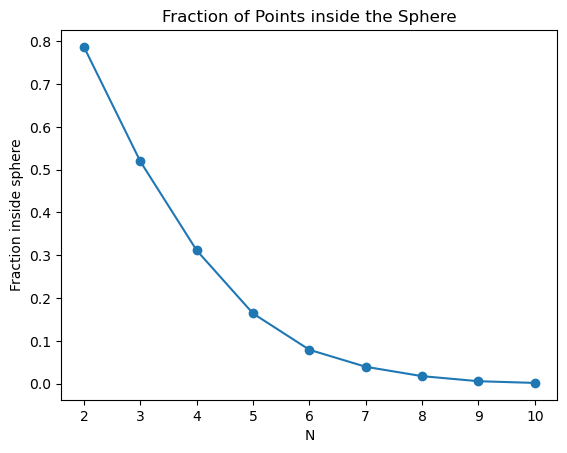

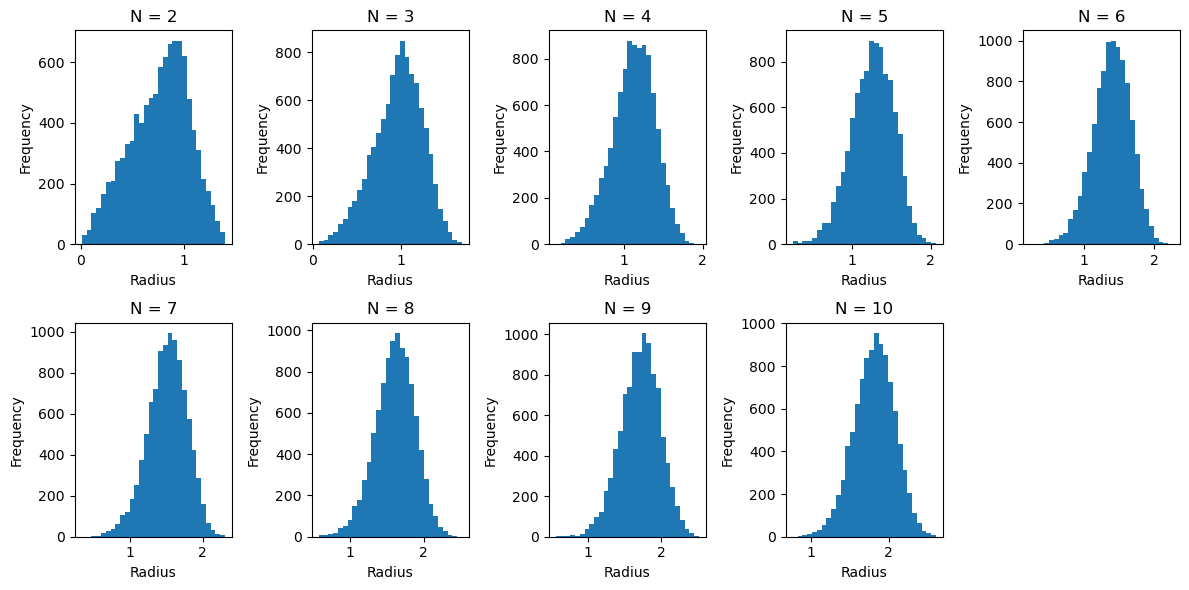

In [6]:
def throw_darts(n_darts, n_dimensions):
    radii = []
    inside_sphere = 0

    for _ in range(n_darts):
        point = np.random.uniform(-1, 1, size=n_dimensions)
        radius = np.linalg.norm(point)
        radii.append(radius)

        if radius <= 1:
            inside_sphere += 1

    fraction_inside = inside_sphere / n_darts
    return radii, fraction_inside

N_values = range(2, 11)
fraction_inside_values = []
radii_histograms = []

for N in N_values:
    radii, fraction_inside = throw_darts(10000, N)
    fraction_inside_values.append(fraction_inside)
    radii_histograms.append(radii)

# Plot fraction inside sphere versus N
plt.figure()
plt.plot(N_values, fraction_inside_values, marker='o')
plt.xlabel('N')
plt.ylabel('Fraction inside sphere')
plt.title('Fraction of Points inside the Sphere')
plt.show()

# Plot histograms of radii for each N
plt.figure(figsize=(12, 6))
for i, radii in enumerate(radii_histograms):
    plt.subplot(2, 5, i + 1)
    plt.hist(radii, bins=30)
    plt.xlabel('Radius')
    plt.ylabel('Frequency')
    plt.title(f'N = {N_values[i]}')

plt.tight_layout()
plt.show()


# Exercise 3-3 
This exercise will explore the relationship between the sparsity K, the signal size n, and the number of samples p in compressed sensing.

(a) For $n = 1000$ and $K=5$ create a K-sparse vector s of Fourier coefficients in a Fourier basis $\Psi$. For each p from 1 to 100, create a Gaussian random
sampling matrix $C\in \mathcal{R}^{p\times n}$ to create a measurement vector $y = C\Phi s$. Use compressed sensing based on this measurement to estimate $\hat{s}$. For each p, repeat this with at least 10 realizations of the random measurement matrix C. Plot the average relative error of $\|\hat{s} - s\|_2/\|s\|_2$ versus p; it may be helpful to visualize the errors with a box-and-whisker plot. Explain the trends. Also plot the average $\ell_1$ and $\ell_0$ error versus p.

(b) Repeat part (a) for $K = 1$ through $K = 50$. What changes?

(c) Now repeat the above experiment for $K = 5$, varying the signal size using $n = 100$, $n = 500$, $n = 1000$, $n = 2000$, and $n = 5000$.

In [7]:
def create_K_sparse_vector(n, K):
    s = np.zeros(n)
    indices = np.random.choice(n, K, replace=False)
    values = np.random.normal(0, 1, K)
    s[indices] = values
    return s

def create_measurement_vector(p, n, K, s):
    C = np.random.normal(0, 1, (p, n))
    y = np.dot(C, np.fft.fft(s))
    return y

In [8]:
def get_optimal_x_for_bp(A, y): # https://stackoverflow.com/questions/56424993/is-there-a-python-implementation-of-a-basis-pursuit-solver
    x_dim, y_dim = A.shape[1], y.shape[0]
    eye = np.eye(x_dim)

    obj = np.concatenate([np.zeros(x_dim), np.ones(x_dim)])

    lhs_ineq = np.concatenate([np.concatenate([eye, -eye], axis=1), np.concatenate([-eye, -eye], axis=1)], axis=0)
    rhs_ineq = np.zeros(2 * x_dim)

    lhs_eq = np.concatenate([A, np.zeros((y_dim, x_dim))], axis=1)
    rhs_eq = y

    bnd = [*((None, None) for _ in range(x_dim)), *((0, None) for _ in range(x_dim))]

    res = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd)
    return res.x[:x_dim]

In [ ]:
n = 1000  # Vector length
K = 5     # Number of non-zero coefficients

avg_relative_error = []
l0_norm = []
l1_norm = []

for p in range(1, 101):
    print(p, '/', 100)
    s = create_K_sparse_vector(n, K)
    Psi = dct(np.identity(n))
    temp_rel = []
    temp_0 = []
    temp_1 = []
    for _ in range(10):
        C = np.random.normal(0, 1, (p, n))
        y = C @ Psi @ s
        s_hat = get_optimal_x_for_bp(C @ Psi, y)
        temp_rel.append(np.linalg.norm(s_hat-s)/np.linalg.norm(s))
        temp_0.append(np.linalg.norm(s-s_hat, ord = 0))
        temp_1.append(np.linalg.norm(s-s_hat, ord = 1))

    avg_relative_error.append(temp)
    l0_norm.append(temp_0)
    l1_norm.append(temp_1)

In [62]:
n = 30  # Vector length
K = 2   # Number of non-zero coefficients

for p in range(1, 2):
    print(p, '/', 100)
    s = create_K_sparse_vector(n, K)
    Psi = dct(np.identity(n))
    print(s)

    for _ in range(1):
        C = np.random.normal(0, 1, (p, n))
        y = C @ Psi @ s
        s_hat = get_optimal_x_for_bp(C @ Psi, y)
        print(s_hat)

1 / 100
[ 0.          0.          0.          0.         -0.93730838  0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -1.20931693  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[-0.19930651 -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.        ]


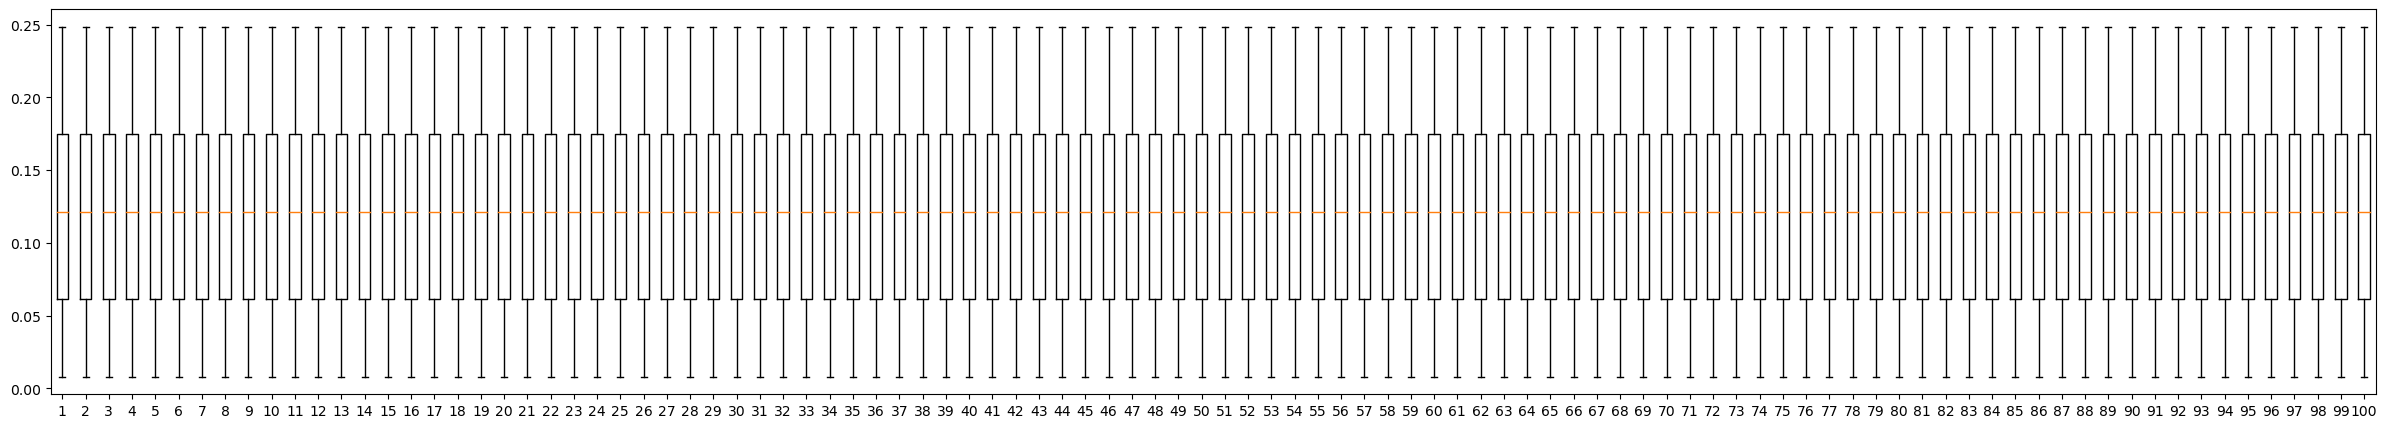

In [12]:
plt.figure(figsize=(30, 5))
plt.boxplot(np.array(avg_relative_error).T)  # Transpose the array to plot rows as columns
plt.show()

# Exercise 3-4
Repeat the above exercise with a uniformly sampled random sample matrix. Also repeat with a Bernoulli random matrix and a matrix that comprises random single pixels. Plot the average relative errors for these different sampling matrices on the same plot (including the plot for Gaussian random
sampling). Discuss the trends.

# Exercise 3-5

Generate a DFT matrix $\Psi$ for $n = 512$. We will use the basis for compressed sensing, and we will compute the incoherence of this basis and different measurement matrices. For $p=16$, create different random measurement matrices $C$ given by Gaussian random measurements, Bernoulli random measurements, and random single-pixel measurements. For each matrix, normalize the length of each row to 1. Now, for each measurement matrix type, compute the incoherence $\mu(C,\Psi)$. Repeat this for many random instances of each $C$ matrix type and compare the histogram of incoherence values for each matrix type. Further, compare the histogram of each inner product $\sqrt{n}\langle c_i,\psi_j\rangle$ for each matrix type. Discuss any trends and the implications for compressed sensing with these measurement matrices. Are there other factors that are relevant for the sensing matrix?


# Exercise 3-6

This exercise will explore sparse representation from Section 3.6 to estimate a fluid flow field, following Callaham et al. [147]. Load the cylinder flow data set. Coarsen each flow field by a factor of 20 in each direction using imresize, and build a library of these coarsened measurements (i.e., a matrix, where each column contains these downsampled measurements). Plot a movie of the flow field in these new coordinates. Now, pick a column of the full flow field matrix and add Gaussian random noise to this field. Downsample the noisy field by a factor of 20 and use SRC to find the closest downsampled library element. Then use this column of the full flow field library as your reconstructed estimate. Try this approach with different levels of noise added to the original flow field. See how much noise is required before the method breaks. Try different approaches to creating a low-dimensional representation of the image (i.e., instead of downsampling, you can measure the flow field in a small 5 × 10 patch and use this as the low-dimensional feature for SRC).

# Exercise 3-7

This exercise will explore RPCA from Section 3.7 for robust flow field analysis, following Scherl et al. [631].

(a) Load the cylinder flow data set. Compute the SVD as in Exercise 1-7 and
plot the movie of the flow. Also plot the singular values and first 10 singular vectors.

(b) Now, contaminate a random 10% of the entries of the data matrix with salt-and-pepper noise. The contaminated points should not be the same for each column, and the salt-and-pepper noise should be $\pm5\eta$, where $\eta$ is the standard deviation of the entire data set. Compute the SVD of the contaminated matrix and plot the movie of the flow along with the singular values and first 10 singular vectors.

(c) Clean the contaminated data set by applying RPCA and keeping the lowrank portion L. Again, compute the SVD of the decontaminated matrix L and plot the movie of the flow along with the singular values and first 10 singular vectors. Compare these with the results from the original clean and contaminated data sets.

(d) Try to clean the data by applying the Gavish–Donoho threshold to the data matrix contaminated with salt-and-pepper noise. Does this work? Explain why or why not.

# Exercise 3-8

This exercise will explore the sparse sensor selection approach based on QR from Section 3.8.

(a) Load the Yale B faces data set. Randomly choose one person to omit from the data matrix and compute the SVD of the remaining data. Compute the QR sensor locations for $p = 100$ using the first $r = 100$ modes of this SVD basis $\tilde{U}$ . Use these sensor locations to reconstruct the images of the person that was left out of the matrix for the SVD. Compare the reconstruction error using these QR sensor locations with reconstruction using $p = 100$ randomly chosen sensors, as in Fig. 3.22.

(b) Now, repeat this experiment 36 times, each time omitting a different person from the data before computing the SVD, and use the sensor locations to reconstruct the images of the omitted person. This will provide enough reconstruction errors on which to perform statistics. For each experiment, also compute the reconstruction error using 36 different configurations of $p = 100$ random sensors. Plot the histograms of the error for the QR and random sensors, and discuss.

(c) Finally, repeat the above experiments for different sensor number $p = 10$ through $p = 200$ in increments of 10. Plot the error distributions versus
p for QR and random sensor configurations. Because each value of p corresponds to many reconstruction errors, it would be best to plot this as a box-and-whisker plot or as a violin plot.

# Exercise 3-9

In the exercise above, for $p=100$, compare the reconstruction results using the $p=100$ QR sensors to reconstruct in the first $r=100$ modes, versus using the same sensors to reconstruct in the first $r=90$ SVD modes. Is one more accurate than the other? Compare the condition number of the $100\times 100$ and $100\times 90$ matrices obtained by sampling the $p$ rows of the $r=100$ and $r=90$ columns of $\tilde{U}$ from the SVD.